In [21]:
# Importing all the essential libraries needed for our Machine Learning models
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import gridspec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [22]:
# Loading the file to perform data preprocessing
Datafile_path = '/Users/veer/Desktop/ML_Project/water use data(buildings).xlsx'
df = pd.read_excel(Datafile_path)

In [23]:
## Remove unnecessary columns that are not required for our model
df = df.drop(columns=['Unnamed: 0', 'Dew Point(C))'])

In [24]:
# Convert the "Date" column to datetime and sort the dataset by this column
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

In [25]:
# The "Date" column contains data in the format "2023-01-01 02:59:59.985", so we round it to the nearest hour
df['Date'] = pd.to_datetime(df['Date']).dt.round('h')

# After rounding the time to the nearest hour, we extract the time from the "Date" column and create a new column
df['Time_Extracted'] = df['Date'].dt.time

# Creating a new column "Hour" from the "Time_Extracted" column to use as a feature for training the model
df['Hour'] = df['Time_Extracted'].apply(lambda t: t.hour)

# Keeping the "Date" column as it is, without the time component
df['Date'] = df['Date'].dt.date

In [26]:
# Mapping 4 Seasons in the Dataset [spring, summer, autumn, winter] to respective numbers to use them as feature
Seasons_Num_Map = {
    'spring': 1,
    'summer': 2,
    'autumn': 3,
    'winter': 4
}

# Creating a new column to map the Seasons by numbers
df['Seasons_num'] = df['Seasons'].map(Seasons_Num_Map)

In [27]:
# Missing Values in the numeric columns are interpolated
num_columns = df.select_dtypes(include='number').columns
df[num_columns] = df[num_columns].interpolate(method='linear')

In [28]:
# Check for any null or NaN values in the dataset
NaN_Cnt = df.isnull().sum().sum()
print('Number of NaN or null values in the dataset:', NaN_Cnt)

Number of NaN or null values in the dataset: 0


In [29]:
# Creating Hourly Lag features for use in the model
for i in range(1, 25):
    df[f'{i}h_Lag'] = df['Water Consumption(GPM)'].shift(i)

In [30]:
# Creating a Lag feature representing the same time from the previous week
df['Last_Week_Same_Time'] = df['Water Consumption(GPM)'].shift(24*7)

In [31]:
#Interpolation of missing values using backward fill interpolation technique
df = df.bfill()

In [32]:
#Interpolation of missing values using linear interpolation technique
df = df.interpolate('linear')

###### One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

In [33]:
# The pre-processed file is saved at the specified location; users can modify this path or skip this step if not needed
Processed_file_path = '/Users/veer/Desktop/ML_Project/Processed_water_use.csv'

# Save the pre-processed DataFrame to a CSV file
df.to_csv(Processed_file_path, index=False)


In [34]:
# Removing the columns not required for model training
df.drop('Seasons', axis=1, inplace=True)
df.drop('Date', axis=1, inplace=True)
df.drop('Time_Extracted', axis=1, inplace=True)

In [35]:
# Setting up the Features (X) and Target (y)
X = df.drop('Water Consumption(GPM)', axis=1)
y = df['Water Consumption(GPM)']

In [36]:
# Splitting the Dataset or DataFrame into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Scale the Features using Standard Scaler in Scikit-Learn
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
# Reshape the data for the LSTM model since TensorFlow requires a 3D input array: [samples, timesteps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [39]:
# Prepare the model for Random Forest (RandomForestRegressor)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions using the trained Random Forest model
rf_predictions = rf.predict(X_test)

# Print the evaluation metrics for the Random Forest model
print("Random Forest RMSE:", root_mean_squared_error(y_test, rf_predictions))
print("Random Forest MAE:", mean_absolute_error(y_test, rf_predictions))
print("RandomForest R^2:", r2_score(y_test, rf_predictions))

Random Forest RMSE: 27.273442820328064
Random Forest MAE: 13.66181875535577
RandomForest R^2: 0.7750892756628496


In [40]:
## Preparing the model using Support Vector Machine Regressor (SVR)
svm = SVR(kernel='rbf')
svm.fit(X_train_scaled, y_train)

# Predicting the values using the trained SVM model
svm_predictions = svm.predict(X_test_scaled)

# Printing the evaluation metrics of the SVM model
print("SVM RMSE:", root_mean_squared_error(y_test, svm_predictions))
print("SVM MAE:", mean_absolute_error(y_test, svm_predictions))
print("SVM R^2:", r2_score(y_test, svm_predictions))

SVM RMSE: 36.38103777696246
SVM MAE: 18.166793313233015
SVM R^2: 0.5997969418598468


In [41]:
# Training the model using ANN Scikit-learn’s MLPRegressor
mlp = MLPRegressor(
    hidden_layer_sizes=(100,), 
    activation='relu', 
    solver='adam',
    alpha=0.0001, 
    learning_rate='adaptive', 
    learning_rate_init=0.001, 
    max_iter=500, 
    early_stopping=True, 
    validation_fraction=0.1, 
    n_iter_no_change=10, 
    random_state=42
)
mlp.fit(X_train_scaled, y_train)

# Predicting the values using the trained MLP model
mlp_predictions = mlp.predict(X_test_scaled)

# Printing the evaluation metrics of the MLP model
print("ANN RMSE:", root_mean_squared_error(y_test, mlp_predictions))
print("ANN MAE:", mean_absolute_error(y_test, mlp_predictions))
print("ANN R^2:", r2_score(y_test, mlp_predictions))

ANN RMSE: 28.531064308970898
ANN MAE: 15.48726346293472
ANN R^2: 0.7538690761586385


In [42]:
# Generate LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Setup Early Stopping to halt training when validation loss does not improve
Early_Stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the LSTM Model on the training data
lstm_model.fit(X_train_reshaped, y_train, epochs=100, validation_split=0.2, callbacks=[Early_Stop], verbose=1)

# Making predictions using the trained LSTM model
lstm_predictions = lstm_model.predict(X_test_reshaped).flatten()

# Evaluate the LSTM model performance
print("LSTM RMSE: ", root_mean_squared_error(y_test, lstm_predictions))
print("LSTM MAE: ", mean_absolute_error(y_test, lstm_predictions))
print("LSTM R^2: ", r2_score(y_test, lstm_predictions))

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - loss: 6974.5645 - val_loss: 5243.9497
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 5029.5938 - val_loss: 2669.1423
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 2389.1875 - val_loss: 1795.0961
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 1579.7152 - val_loss: 1534.7656
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 1468.3885 - val_loss: 1402.7030
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 1229.7992 - val_loss: 1297.4546
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 1237.3193 - val_loss: 1200.1219
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 1106.0928 - val_loss: 1130.8068
Epoch 9/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 1204.3225 - val_loss: 1069.4536
Epoch 10/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 1122.6644 - val_loss: 1027.0360
Epoch 11/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - los

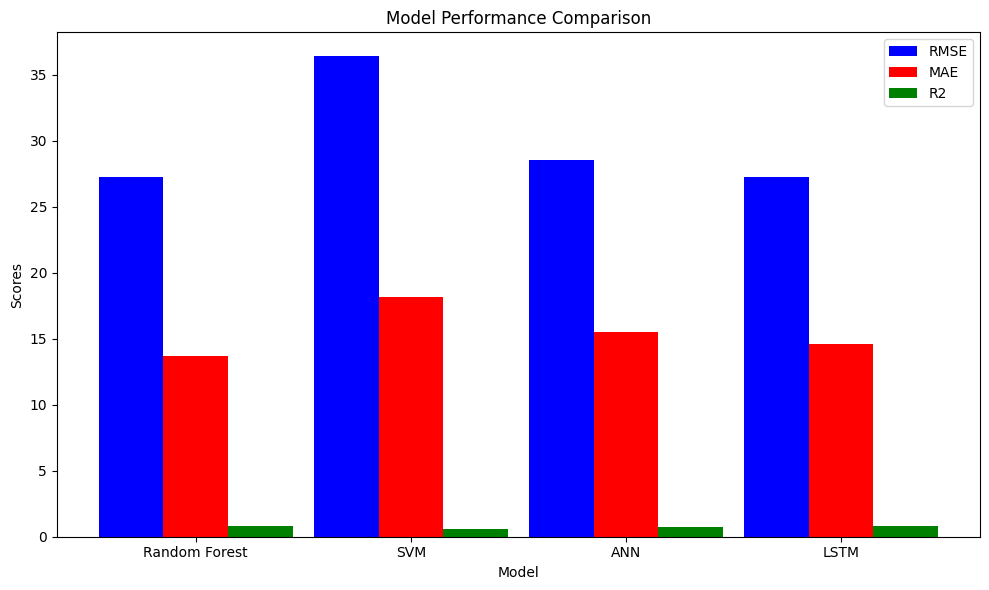

In [28]:
# Defining a function to compare and visualize the performance of models using bar graphs
def compare_models(models, rmse_scores, mae_scores, r2_scores):
    plt.figure(figsize=(10, 6))  # Setting the figure's size

    n = len(models)
    index = np.arange(n)
    bar_width = 0.30  # Setting the position of the bar graphs

    # Creating the bars for the Root Mean Square Error Scores
    plt.bar(index, rmse_scores, bar_width, label='RMSE', color='blue')

    # Creating the bars for the Mean Absolute Error Scores
    plt.bar(index + bar_width, mae_scores, bar_width, label='MAE', color='red')

    # Creating the bars for the R-Squared Scores
    plt.bar(index + 2 * bar_width, r2_scores, bar_width, label='R2', color='green')

    # Setting the Title and Axis Labels
    plt.title('Model Performance Comparison')
    plt.xlabel('Model')
    plt.xticks(index + bar_width, models)
    plt.ylabel('Scores')

    # Adding a legend to differentiate between multiple plots
    plt.legend()

    # Displaying the plot with all the scores
    plt.tight_layout()
    plt.show()

# Defining the performance metrics to compare the models
models = ['Random Forest', 'SVM', 'ANN', 'LSTM']
rmse_scores = [root_mean_squared_error(y_test, rf_predictions),
               root_mean_squared_error(y_test, svm_predictions),
               root_mean_squared_error(y_test, mlp_predictions),
               root_mean_squared_error(y_test, lstm_predictions)]

mae_scores = [mean_absolute_error(y_test, rf_predictions),
              mean_absolute_error(y_test, svm_predictions),
              mean_absolute_error(y_test, mlp_predictions),
              mean_absolute_error(y_test, lstm_predictions)]

r2_scores = [r2_score(y_test, rf_predictions),
             r2_score(y_test, svm_predictions),
             r2_score(y_test, mlp_predictions),
             r2_score(y_test, lstm_predictions)]

# Calling the function to compare the models
compare_models(models, rmse_scores, mae_scores, r2_scores)

Enter Date and Time (YYYY-MM-DD HH:MM):  2023-06-13 03:00


Predicted water usage for 2023-06-13 03:00 is 13.34322627134771 Gal
Actual Water usage for 2023-06-12 03:00 is 11.5904870613 Gal
Actual Water usage for 2023-06-11 03:00 is 8.88604008033 Gal
Actual Water usage for 2023-06-10 03:00 is 14.29493404227 Gal
Actual Water usage for 2023-06-06 03:00 is 9.27238964904 Gal

Oh, I am sorry, but your water use at the time would be higher than the recent average. What about participating in saving water today? 
Thanks!


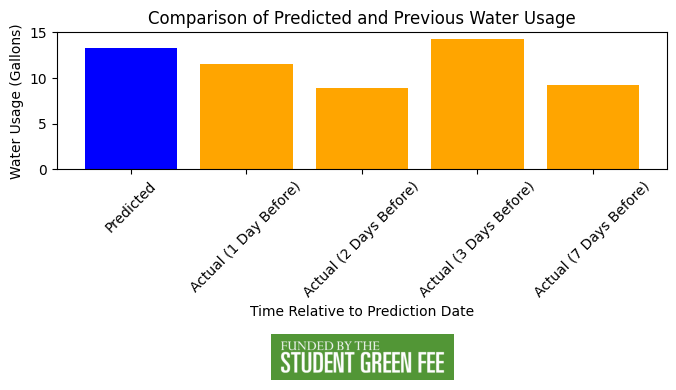

In [43]:
# Initialize the start date
start_date = datetime(2023, 1, 1)

def map_to_datetime(hour, day_offset):
    return start_date + timedelta(days=day_offset, hours=hour)

# Assuming df is your DataFrame and it has a 'Hour' column
df['Datetime'] = [map_to_datetime(row['Hour'], idx // 24) for idx, row in df.iterrows()]

def print_actual_demands(input_datetime, df):
    actual_demands = {}
    year_in_dataset = 2023
    adjusted_datetime = input_datetime.replace(year=year_in_dataset)
    days_to_check = [1, 2, 3, 7]

    for days in days_to_check:
        target_datetime = adjusted_datetime - timedelta(days=days)
        matching_row = df[df['Datetime'] == target_datetime]
        if not matching_row.empty:
            actual_demand = matching_row.iloc[0]['Water Consumption(GPM)']
            actual_demands[f"Actual ({days} Day{'s' if days > 1 else ''} Before)"] = actual_demand
            print(f"Actual Water usage for {target_datetime.strftime('%Y-%m-%d %H:%M')} is {actual_demand} Gal")
        else:
            print(f"No data available for {target_datetime.strftime('%Y-%m-%d %H:%M')}")
            actual_demands[f"Actual ({days} Day{'s' if days > 1 else ''} Before)"] = None
    return actual_demands

def find_matching_date(input_datetime, df):
    matching_rows = df[(df['Datetime'].dt.month == input_datetime.month) & 
                       (df['Datetime'].dt.day == input_datetime.day) & 
                       (df['Datetime'].dt.hour == input_datetime.hour)].copy()
    if not matching_rows.empty:
        matching_rows['time_diff'] = abs(matching_rows['Datetime'] - input_datetime)
        closest_row = matching_rows.loc[matching_rows['time_diff'].idxmin()]
        return closest_row
    return pd.DataFrame()

def predict_demand(input_date_time_str, df, model, features_used):
    input_datetime = pd.to_datetime(input_date_time_str)
    matching_row = find_matching_date(input_datetime, df)
    if not matching_row.empty:
        features = matching_row[features_used].to_frame().transpose()
        prediction = model.predict(features)
        return prediction[0], matching_row
    print("No matching date found in the dataset.")
    return None, None

def print_water_usage_warning(predicted_demand, actual_demands):
    actual_values = [demand for demand in actual_demands.values() if demand is not None]
    if actual_values:
        average_actual_demand = sum(actual_values) / len(actual_values)
        if predicted_demand > average_actual_demand:
            print("\nOh, I am sorry, but your water use at the time would be higher than the recent average. What about participating in saving water today? \nThanks!")
        else:
            print("\nGreat news! Your water usage at the time would be within the normal range compared to the recent average.")
    else:
        print("\nInsufficient data to compare predicted and actual demands.")

def visualize_demands(predicted_demand, actual_demands):
    labels = ['Predicted'] + list(actual_demands.keys())
    values = [predicted_demand] + list(actual_demands.values())
    
    plt.figure(figsize=(7, 4))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    ax2 = plt.subplot(gs[1])
    img = mpimg.imread(image_path)
    ax2.imshow(img)
    ax2.axis('off')

    ax1 = plt.subplot(gs[0])
    ax1.bar(labels, values, color=['blue'] + ['orange'] * len(actual_demands))
    ax1.set_title('Comparison of Predicted and Previous Water Usage')
    ax1.set_xlabel('Time Relative to Prediction Date')
    ax1.set_ylabel('Water Usage (Gallons)')
    ax1.set_xticks(range(len(labels)))
    ax1.set_xticklabels(labels, rotation=45)

    plt.tight_layout()
    plt.show()


input_date_time_str = input("Enter Date and Time (YYYY-MM-DD HH:MM): ")
input_datetime = pd.to_datetime(input_date_time_str)
features_used = X_train.columns.tolist()  # Assuming X_train is defined
predicted_demand, _ = predict_demand(input_date_time_str, df, rf, features_used)
image_path = '/Users/veer/Desktop/ML_Project/Green_Fee_Marker.png'

# Print the predicted demand and actual demands
if predicted_demand is not None:
    print(f"Predicted water usage for {input_date_time_str} is {predicted_demand} Gal")
    actual_demands = print_actual_demands(input_datetime, df)
    print_water_usage_warning(predicted_demand, actual_demands)
    visualize_demands(predicted_demand, actual_demands)